In [9]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [10]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
path = '../Neuro_dataset/'
path_alz = path + os.listdir(path)[1]
path_nor = path + os.listdir(path)[2]

In [12]:
files_alz = os.listdir(path_alz)
files_nor = os.listdir(path_nor)
d = loadmat(path_alz + '/' + files_alz[0])
d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
X_aal = d['tc_rest_aal']
X_pow = d['tc_rest_power']

for i in range(1, len(files_alz)):
    d = loadmat(path_alz + '/' + files_alz[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

for i in range(len(files_nor)):
    d = loadmat(path_nor + '/' + files_nor[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

In [13]:
y = [1 for i in range(34)]
y.extend([0 for i in range(47)])
y = np.array(y).reshape((81, 1))
y.shape

(81, 1)

In [14]:
X_pow = X_pow.reshape(X_pow.shape[0], X_pow.shape[1]*X_pow.shape[2])
X_aal = X_aal.reshape(X_aal.shape[0], X_aal.shape[1]*X_aal.shape[2])
print(X_pow.shape, X_aal.shape)

(81, 36960) (81, 16240)


In [7]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_aal)
X = pca.fit_transform(X_aal)

In [55]:
X.shape

(81, 81)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_aal, y, test_size = 0.4)
print(X_train.shape, X_test.shape)

(48, 16240) (33, 16240)


In [17]:
lam = tf.keras.regularizers.l2(l2=10)
# lam_2 = tf.keras.regularizers.l2(l=0.01)
init = tf.initializers.he_normal()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_dim=X_train.shape[1], kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(1024, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(32, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init, kernel_regularizer=lam)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2078848   
_________________________________________________________________
re_lu_3 (ReLU)               (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              132096    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [18]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/100
12/12 [==============================] - 2s 43ms/step - loss: 21454.4946 - accuracy: 0.4920 - val_loss: 17537.5293 - val_accuracy: 0.5152
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 16745.6164 - accuracy: 0.7611 - val_loss: 14550.8115 - val_accuracy: 0.4545
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 13986.6796 - accuracy: 0.5266 - val_loss: 12218.4033 - val_accuracy: 0.5152
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 11718.6102 - accuracy: 0.6962 - val_loss: 10233.4961 - val_accuracy: 0.4545
Epoch 5/100
12/12 [==============================] - 0s 16ms/step - loss: 9795.9939 - accuracy: 0.7127 - val_loss: 8492.1113 - val_accuracy: 0.4545
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 8110.5821 - accuracy: 0.7606 - val_loss: 6975.1768 - val_accuracy: 0.4242
Epoch 7/100
12/12 [==============================] - 0s 16ms/step - loss: 6650.4704 - accuracy: 0.7800 -

In [20]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

Accuracy is: 57.57575757575758


<AxesSubplot:>

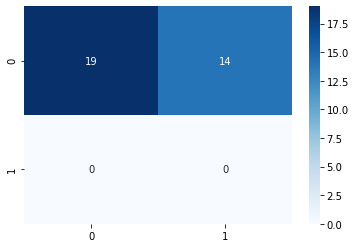

In [22]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g', cmap='Blues')

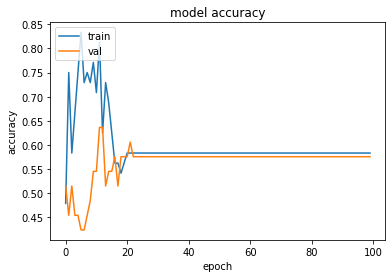

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

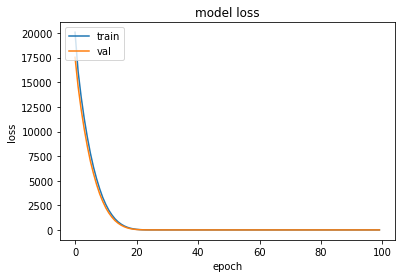

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()